<a href="https://colab.research.google.com/github/tomreitz/cs766-computer-vision-project/blob/main/code/10k_faces_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


                     count unique  \
image                 5513  5513    
bytes                 5513  NaN     
width                 5513  NaN     
height                5513  NaN     
age                   5513  NaN     
gender                5513  2       
forehead              5513  NaN     
frown                 5513  NaN     
upper_eye_hood_left   5513  NaN     
upper_eye_hood_right  5513  NaN     
crows_feet_left       5513  NaN     
crows_feet_right      5513  NaN     
bunny_lines_left      5513  NaN     
bunny_lines_right     5513  NaN     
bags_left             5513  NaN     
bags_right            5513  NaN     
laugh_lines_left      5513  NaN     
laugh_lines_right     5513  NaN     
jowls_left            5513  NaN     
jowls_right           5513  NaN     
lip_lines             5513  NaN     
mental_crease         5513  NaN     
dim                   5513  NaN     

                                                                        top  \
image                 imdb_crop/

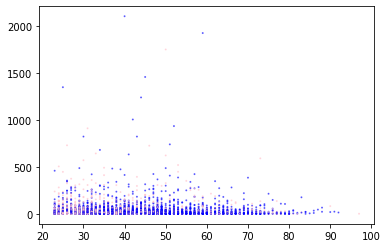

frown


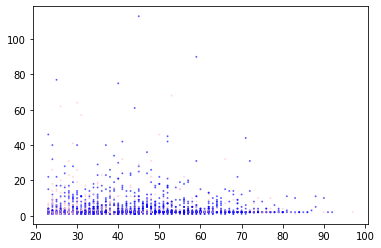

upper_eye_hood_left


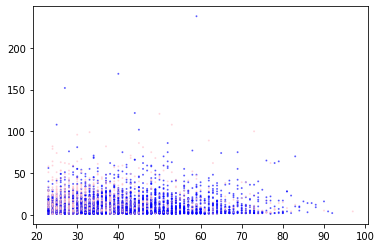

upper_eye_hood_right


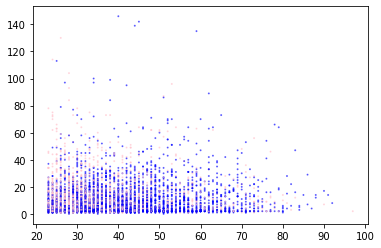

crows_feet_left


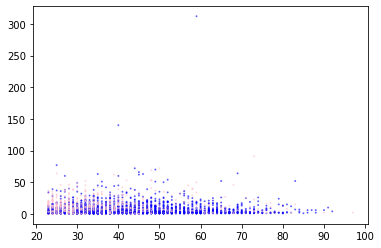

crows_feet_right


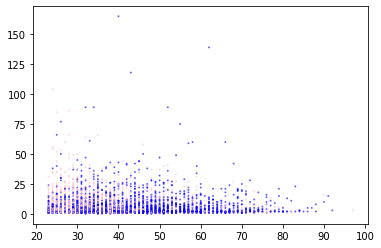

bunny_lines_left


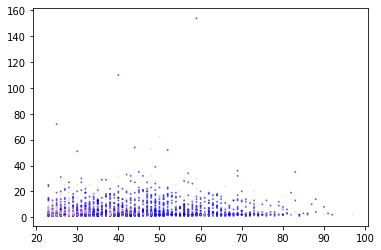

bunny_lines_right


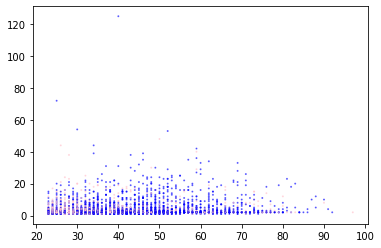

bags_left


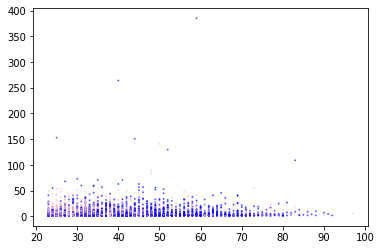

bags_right


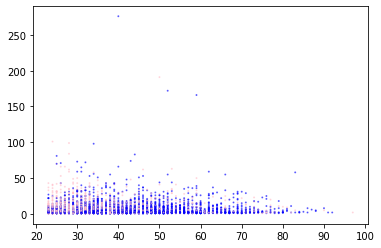

laugh_lines_left


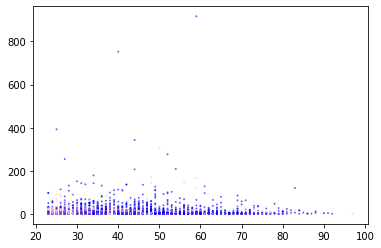

laugh_lines_right


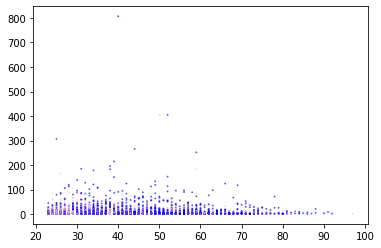

jowls_left


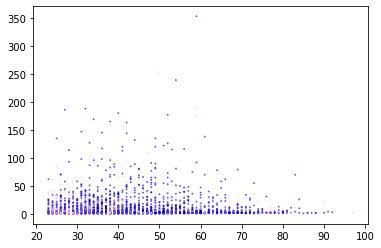

jowls_right


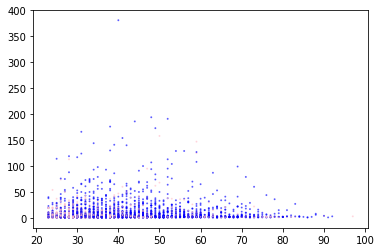

lip_lines


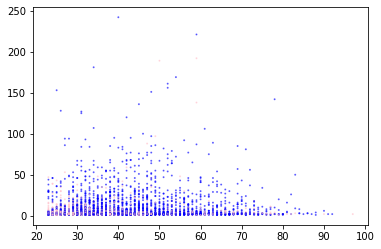

mental_crease


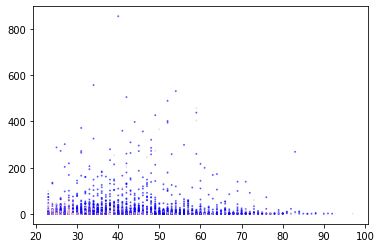

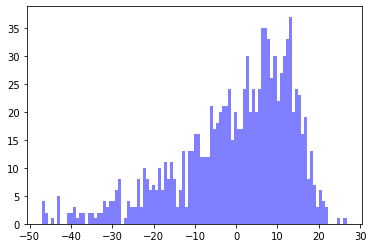

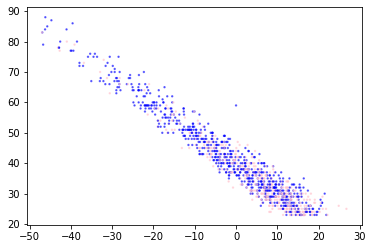

Avg. error:
11.023934723481423
Random guess error:
10.579681595648188


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

df = pd.read_csv("10k-faces.csv") # <----------------- You need to uplaod this into the notbook
#print(df.loc[:, df.columns!='image'].transpose())

# Add some derived columns to the data:
#df['total_lines'] = df.forehead + df.frown + df.upper_eye_hood_left + df.upper_eye_hood_right + df.crows_feet_left + df.crows_feet_right + df.bunny_lines_left + df.bunny_lines_right+ df.bags_left + df.bags_right + df.laugh_lines_left + df.laugh_lines_right + df.jowls_left + df.jowls_right + df.lip_lines + df.mental_crease
df['dim'] = df.width * df.height

# Filter the data for decent-sized images (some in this set are tiny, like 50x50 pixels)
# and faces that might actually be old enough to have some wrinkles.
df = df.query('width>=200 & height>=200 & age>22')
df = df.reset_index(drop=True)

# Show some descriptive statistics of the dataset:
print(df.describe(include='all').transpose())

rhytide_cols = ['forehead', 'frown', 'upper_eye_hood_left', 'upper_eye_hood_right', 'crows_feet_left', 'crows_feet_right', 'bunny_lines_left', 'bunny_lines_right', 'bags_left', 'bags_right', 'laugh_lines_left', 'laugh_lines_right', 'jowls_left', 'jowls_right', 'lip_lines', 'mental_crease']
colors = {'male':'blue', 'female':'pink'}
# Print out a scatterplot of rhytide values vs. age for each rhytide type. Any correlations? doesn't look like it :(
for rhy in rhytide_cols:
  print(rhy)
  data = df.loc[:, ['dim','age','gender',rhy]]
  #data = data.loc[data['total_lines']<1500]
  data = data.loc[data['dim']>10000]
  plt.scatter(data.loc[:,'age'], data.loc[:,rhy], s=1, c=data.loc[:,'gender'].map(colors), alpha=0.5)
  plt.show()

# For training, we need to strip out all columns except the rhytide types
keep_cols = ['forehead', 'frown', 'upper_eye_hood_left', 'upper_eye_hood_right', 'crows_feet_left', 'crows_feet_right', 'bunny_lines_left', 'bunny_lines_right', 'bags_left', 'bags_right', 'laugh_lines_left', 'laugh_lines_right', 'jowls_left', 'jowls_right', 'lip_lines', 'mental_crease']
data = df.loc[:, keep_cols]

# Make our training (random 80%) and testing (other 20%) sets
train_80 = data.sample(frac = 0.8)
test_20 = data.drop(train_80.index)

# Set up and fit a KNN model
nrst_neigh = NearestNeighbors(n_neighbors = 15, algorithm = 'ball_tree')
nrst_neigh.fit(train_80)

# Calculate nearest neighbors for each element of the test set:
distances, indices = nrst_neigh.kneighbors(test_20)

# Now we want to compute a prediction error array for each test set element.
errors = np.zeros(len(test_20))
random_guess_error = np.zeros(len(test_20))
for i in range(1,len(test_20)):
  # Compare average of the ages corresponding to the nearest neighbors vs. the true age
  # (we look up both in the original dataset, since they've been stripped out of the train/test sets)
  errors[i] = np.average(df.loc[indices[i],'age']) - df.loc[test_20.index[i], 'age']
  random_guess_error[i] = 39.6902 - df.loc[test_20.index[i], 'age']

# Plot a histogram of error values, to see if there's any skew (more error in younger faces?)
num_bins = 100
n, bins, patches = plt.hist(errors, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Show scatter plot of error in individual elements of the test set vs. age, colored by gender
plt.scatter(errors, df.loc[test_20.index, 'age'], c=df.loc[test_20.index, 'gender'].map(colors), s=2, alpha=0.5)
plt.show()

# Is our average prediction error any better than random guessing? (if we always predict the mean age of the dataset)
print('Avg. error:')
print(sum(abs(errors))/len(test_20))
print('Random guess error:')
print(sum(abs(random_guess_error))/len(test_20))
